In [1]:
import pyspark
import re
import numpy as np

In [2]:
%env JAVA_HOME = /usr/lib/jvm/java-8-openjdk-amd64

env: JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64


In [3]:
sc = pyspark.SparkContext()

In [4]:
# Load sample data, which has 10,000 and 50,000 rows
application = sc.textFile ("application_data_sample.csv")
previous_application = sc.textFile ("previous_application_sample.csv")

In [5]:
# Rows are lists 
cleaned_application = application.flatMap(lambda x: [x.split(',')])
cleaned_previous = previous_application.flatMap(lambda x: [x.split(',')])

# Columns to keep 
application_keep = [0, 3, 4, 5, 7, 8, 9, 10, 13, 14, 17, 18, 25, 27, 116, 117, 118, 119]
previous_keep = [1, 16]

# Filter
filtered_application = cleaned_application.map(lambda x: [x[i] for i in application_keep])
filtered_previous = cleaned_previous.map(lambda x: [x[i] for i in previous_keep])

# Key, values with key as ID 
kv_application = filtered_application.map(lambda x: (x[0], x[1:]))
kv_previous = filtered_previous.map(lambda x: (x[0], x[1:]))

In [6]:
# Kept columns in application: 
kv_application.first()

('SK_ID_CURR',
 ['CODE_GENDER',
  'FLAG_OWN_CAR',
  'FLAG_OWN_REALTY',
  'AMT_INCOME_TOTAL',
  'AMT_CREDIT',
  'AMT_ANNUITY',
  'AMT_GOODS_PRICE',
  'NAME_EDUCATION_TYPE',
  'NAME_FAMILY_STATUS',
  'DAYS_BIRTH',
  'DAYS_EMPLOYED',
  'FLAG_CONT_MOBILE',
  'FLAG_EMAIL',
  'AMT_REQ_CREDIT_BUREAU_HOUR',
  'AMT_REQ_CREDIT_BUREAU_DAY',
  'AMT_REQ_CREDIT_BUREAU_WEEK',
  'AMT_REQ_CREDIT_BUREAU_MON'])

In [7]:
# Kept columns in previous: 
kv_previous.first()

('SK_ID_CURR', ['NAME_CONTRACT_STATUS'])

In [8]:
# Join application and previous 

joined = kv_application.join(kv_previous)
joined_no_index = joined.map(lambda x: (x[1][0] + x[1][1]))

# Filter rows that do not have 'Approved' or 'Refused'
filtered_decision = joined_no_index.filter(lambda x: (x[-1] == 'Approved' or x[-1] == 'Refused'))
# Change approved/denied to binary 1/0 
binary_decision = filtered_decision.map(lambda x: (x[:-1] + ['1'] if x[-1] == 'Approved' else x[:-1] + ['0']))

In [9]:
binary_decision.first()

['F',
 'N',
 'N',
 '67500.0',
 '331920.0',
 '17077.5',
 '225000.0',
 'Secondary / secondary special',
 'Married',
 '-13280',
 '-280',
 '1',
 '0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '1']

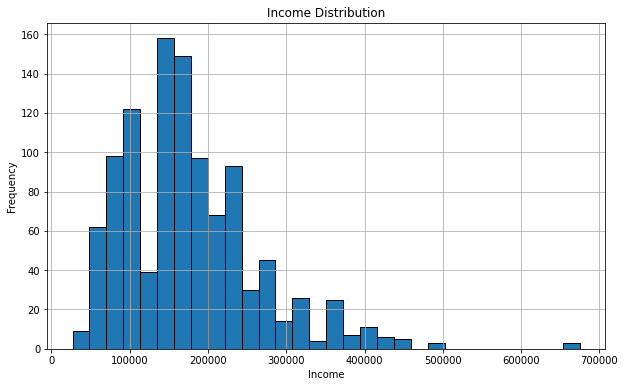

In [10]:
import matplotlib.pyplot as plt

incomes = binary_decision.map(lambda x: float(x[3])).collect()

plt.figure(figsize=(10, 6))
plt.hist(incomes, bins=30, edgecolor='black')
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
'''
To implement conditional demographic parity, add a column for income bracket.
Above, I looked at the income distribution to decide on buckets to use. 
1 = 0-100k
2 = 100-200k
3 = 200k 
'''

def income_cat(x):
    if float(x[3]) < 100000: 
        return list(x) + ['1']
    elif float(x[3]) < 200000: 
        return list(x) + ['2']
    else: 
        return list(x) + ['3']

# Add the category in the last column 
income_category = binary_decision.map(lambda x: income_cat(x))

In [12]:
# Safe division 
def safe_div(n, d):
    return float(n) / float(d) if float(d) != 0 else 0

def bias_analysis(bias_index, inputRDD):    

    # Number of accepted loans per potential bias  
    bias_key = inputRDD.map(lambda x: (x[bias_index], int(x[17])))
    bias_accepted = bias_key.reduceByKey(lambda x, y: int(x) + int(y))

    # Total loans request per potential bias   
    bias_total_key = inputRDD.map(lambda x: (x[bias_index], 1))
    bias_total = bias_total_key.reduceByKey(lambda x, y: x + y)

    # Insert in python list. Shape is [(cat, value), ...]
    bias_accepted_list = bias_accepted.collect()
    bias_total_list = bias_total.collect()

    # Total number of accepted applicants 
    total_accepted = 0
    for _, value in bias_accepted_list:
        total_accepted += value
    
    # Approval Rates. Shape is [(cat, value), ...]
    AR = [(accepted_tup[0], safe_div(accepted_tup[1], total_tup[1])) 
          for accepted_tup, total_tup 
          in zip(bias_accepted_list, bias_total_list)]
    

    # Demographic Parity Difference & Disparate Impact Ratio 
    # extract just the approval rates per category
    rates = [ rate for (_, rate) in AR ]
    if rates:
        DPD = max(rates) - min(rates)
        DIR = safe_div(min(rates), max(rates))
    else:
        DPD = 0
        DIR = None

    # Balance for Positive Class
    # proportions of total accepted for each category
    total_acceptance = [safe_div(val, total_accepted)
                         for (_, val) in bias_accepted_list]
    if total_acceptance:
        BPC = max(total_acceptance) - min(total_acceptance)
    else:
        BPC = 0

            
    # Number of accepted loans per bias and income
    bias_income_key = inputRDD.map(lambda x: ((x[bias_index], x[18]), x[17]))
    bias_income_accepted = bias_income_key.reduceByKey(lambda x, y: int(x) + int(y))

    # Total number of accepted loans per bias and income
    bias_income_total_key = inputRDD.map(lambda x: ((x[bias_index], x[18]), 1))
    bias_income_total = bias_income_total_key.reduceByKey(lambda x, y: x + y)

    # Insert in python list 
    bias_income_accepted_list = bias_income_accepted.collect()
    bias_income_total_list = bias_income_total.collect()

    # Approval rate for different income brackets 
    AR_low = [(accepted_tup[0], safe_div(accepted_tup[1], total_tup[1])) 
              for accepted_tup, total_tup
              in zip(bias_income_accepted_list, bias_income_total_list)
              if accepted_tup[0] == total_tup[0] and accepted_tup[0][1] == '1']
    
    AR_mid = [(accepted_tup[0], safe_div(accepted_tup[1], total_tup[1])) 
              for accepted_tup, total_tup
              in zip(bias_income_accepted_list, bias_income_total_list)
              if accepted_tup[0] == total_tup[0] and accepted_tup[0][1] == '2']
    
    AR_high = [(accepted_tup[0], safe_div(accepted_tup[1], total_tup[1])) 
              for accepted_tup, total_tup
              in zip(bias_income_accepted_list, bias_income_total_list)
              if accepted_tup[0] == total_tup[0] and accepted_tup[0][1] == '3']
    
    # List of lists of approval rates for bias and income 
    AR_list = [AR_low, AR_mid, AR_high]
    
    # Conditional demographic parity
    CDP_list = []
    
    for AR_group in AR_list:
        
        # Find CDP for each bracket 
        rates = [ rate for (_, rate) in AR_group ] 
        
        # If null, 0
        if not rates:
            CDP_list.append(0)
        else:
            CDP_list.append(max(rates) - min(rates))

    # Find size of each group 
    group_low = sum(value for (cat, value) in bias_income_total_list if cat[1] == '1')
    group_mid = sum(value for (cat, value) in bias_income_total_list if cat[1] == '2')
    group_high= sum(value for (cat, value) in bias_income_total_list if cat[1] == '3')

    group_list = [group_low, group_mid, group_high]
    total_size = sum(group_list)

    # Explained Disparity 
    ED = 0
    for cdp, size in zip(CDP_list, group_list):
        ED += cdp * size / total_size

    # Unexplained Disparity 
    UD = DPD - ED 
    
    return AR, DPD, DIR, BPC, UD

# **Analysis for small dataset**

# **Gender Analysis**

In [27]:
gender_input = income_category.filter(lambda x: x[0] in ['F', 'M'])

In [28]:
AR, DPD, DIR, BPC, UD = bias_analysis(0, gender_input)   
print(f'Gender values:\n\
  Approval rate: {AR}\n\
  Demographic Parity Difference: {DPD}\n\
  Disparate Impact Ratio: {DIR}\n\
  Balance for Positive Class: {BPC}\n\
  Unexplained disparity: {UD}')

Gender values:
  Approval rate: [('F', 0.7863013698630137), ('M', 0.813953488372093)]
  Demographic Parity Difference: 0.027652118509079338
  Disparate Impact Ratio: 0.966027397260274
  Balance for Positive Class: 0.3442622950819672
  Unexplained disparity: -0.008082788042391584


# **Family Status Analysis**

In [29]:
def clean_marriage(x):
    new = list(x)
    try:
        if x[8] in ['Married', 'Civil marriage']:
            new[8] = 'Married'
        elif x[8] in ['Single / not married', 'Separated', 'Widow']:
            new[8] = 'Single'
        else:
            return None  
        return new
    except:
        return None

marriage_input = income_category.map(lambda x: clean_marriage(x)).filter(lambda x: x is not None)


In [30]:
AR, DPD, DIR, BPC, UD = bias_analysis(8, marriage_input)   
print(f'Family status values:\n\
  Approval rates: {AR}\n\
  Demographic Parity Difference: {DPD}\n\
  Disparate Impact Ratio: {DIR}\n\
  Balance for Positive Class: {BPC}\n\
  Unexplained disparity: {UD}')

Family status values:
  Approval rates: [('Married', 0.7981770833333334), ('Single', 0.7870036101083032)]
  Demographic Parity Difference: 0.01117347322503015
  Disparate Impact Ratio: 0.9860012602988203
  Balance for Positive Class: 0.4753309265944645
  Unexplained disparity: -0.02996602487178382


# **Education Type Analysis**

In [31]:
def clean_education(x):
    new = list(x)
    try:
        if x[7] in ['Higher education', 'Academic degree']:
            new[7] = 'Higher Education'
        elif x[7] in ['Secondary / secondary special', 'Lower secondary', 'Incomplete higher', 'Commercial associate']:
            new[7] = 'Lower Education'
        else:
            return None 
        return new
    except:
        return None

education_input = income_category.map(lambda x: clean_education(x)).filter(lambda x: x is not None)


In [32]:
AR, DPD, DIR, BPC, UD = bias_analysis(7, education_input)   
print(f'Education type values:\n\
  Approval rates: {AR}\n\
  Demographic Parity Difference: {DPD}\n\
  Disparate Impact Ratio: {DIR}\n\
  Balance for Positive Class: {BPC}\n\
  Unexplained disparity: {UD}')

Education type values:
  Approval rates: [('Lower Education', 0.8017456359102244), ('Higher Education', 0.7701612903225806)]
  Demographic Parity Difference: 0.03158434558764378
  Disparate Impact Ratio: 0.9606055285205438
  Balance for Positive Class: 0.5419664268585132
  Unexplained disparity: -0.030408218829403616


# **Car Ownership Analysis**

In [33]:
car_input = income_category.filter(lambda x: x[1] in ['Y', 'N'])

In [34]:
AR, DPD, DIR, BPC, UD = bias_analysis(1, car_input)   
print(f'Car Ownership values:\n\
  Approval rates: {AR}\n\
  Demographic Parity Difference: {DPD}\n\
  Disparate Impact Ratio: {DIR}\n\
  Balance for Positive Class: {BPC}\n\
  Unexplained disparity: {UD}')

Car Ownership values:
  Approval rates: [('N', 0.7739130434782608), ('Y', 0.8333333333333334)]
  Demographic Parity Difference: 0.05942028985507253
  Disparate Impact Ratio: 0.9286956521739129
  Balance for Positive Class: 0.2505854800936768
  Unexplained disparity: -0.005725652730549896


# **Technology Analysis**

In [37]:
phone_input = income_category.filter(lambda x: x[11] in ['0', '1'])

In [38]:
AR, DPD, DIR, BPC, UD = bias_analysis(11, phone_input)   
print(f'Technology availibility values:\n\
  Approval rates: \n\
    Could be contacted by phone: {AR[0][1]}\n\
    Could not be contacted by phone: {AR[1][1]}\n\
  Demographic Parity Difference: {DPD}\n\
  Disparate Impact Ratio: {DIR}\n\
  Balance for Positive Class: {BPC}\n\
  Unexplained disparity: {UD}')

Technology availibility values:
  Approval rates: 
    Could be contacted by phone: 0.7956273764258555
    Could not be contacted by phone: 0.7727272727272727
  Demographic Parity Difference: 0.022900103698582752
  Disparate Impact Ratio: 0.9712175518627132
  Balance for Positive Class: 0.9601873536299765
  Unexplained disparity: -0.11433140803620859


# **Age Analysis**

In [39]:
# Modify age to have a range 

def age(x):
    new = list(x)
    
    if abs(float(x[9])) < 30 * 365: 
        new[9] = '< 30'
    else: 
        new[9] = '> 30'

    return new

# Add the category in the last column 
age_input = income_category.map(lambda x: age(x))

In [40]:
AR, DPD, DIR, BPC, UD = bias_analysis(9, age_input)   
print(f'Age values:\n\
  Approval rates: {AR}\n\
  Demographic Parity Difference: {DPD}\n\
  Disparate Impact Ratio: {DIR}\n\
  Balance for Positive Class: {BPC}\n\
  Unexplained disparity: {UD}')

Age values:
  Approval rates: [('< 30', 0.7823529411764706), ('> 30', 0.797566371681416)]
  Demographic Parity Difference: 0.015213430504945391
  Disparate Impact Ratio: 0.9809251856082238
  Balance for Positive Class: 0.6885245901639345
  Unexplained disparity: -0.016745516682815174


Outputs of running with the large dataset with AWS 

Gender values:                                                                                                                                                                                                
  Approval rate: [('M', 0.7779490407718839), ('F', 0.7857100333189351)]                                                                                                                                       
  Demographic Parity Difference: 0.007760992547051204                                                                                                                                                         
  Disparate Impact Ratio: 0.9901223196625505                                                                                                                                                                  
  Balance for Positive Class: 0.3512108915970755                                                                                                                                                              
  Unexplained disparity: 0.005332553792893554   
  
  
Family status values:                                                                                                                                                                                         
  Approval rates: [('Married', 0.7848993866807843), ('Single', 0.7734882421034349)]                                                                                                                           
  Demographic Parity Difference: 0.011411144577349375                                                                                                                                                         
  Disparate Impact Ratio: 0.9854616467142301                                                                                                                                                                  
  Balance for Positive Class: 0.4826726324237087                                                                                                                                                              
  Unexplained disparity: 0.005182456759545815     
  
  
Education type values:                                                                                                                                                                                        
  Approval rates: [('Higher Education', 0.7820345024074464), ('Lower Education', 0.7821630177013015)]                                                                                                         
  Demographic Parity Difference: 0.00012851529385504712                                                                                                                                                       
  Disparate Impact Ratio: 0.9998356924439706                                                                                                                                                                  
  Balance for Positive Class: 0.5592575303971015                                                                                                                                                              
  Unexplained disparity: -0.007611379471703185     
  
  
Car Ownership values:                                                                                                                                                                                         
  Approval rates: [('N', 0.7849523421731861), ('Y', 0.7797102054315118)]                                                                                                                                      
  Demographic Parity Difference: 0.005242136741674286                                                                                                                                                         
  Disparate Impact Ratio: 0.9933217133575765                                                                                                                                                                  
  Balance for Positive Class: 0.3201410328454781                                                                                                                                                              
  Unexplained disparity: 0.0031091345450214867       
  
  
  
Technology availibility values:                                                                                                                                                                               
  Approval rates:                                                                                                                                                                                             
    Could be contacted by phone: 0.7820873218421496                                                                                                                                                           
    Could not be contacted by phone: 0.8202637331418335                                                                                                                                                       
  Demographic Parity Difference: 0.038176411299683966                                                                                                                                                         
  Disparate Impact Ratio: 0.9534583698422726                                                                                                                                                                  
  Balance for Positive Class: 0.9408782068765067                                                                                                                                                              
  Unexplained disparity: 0.0015518830415907903       
  
  
  
Age values:                                                                                                                                                                                                   
  Approval rates: [('< 30', 0.7699793021590496), ('> 30', 0.7856585806345688)]                                                                                                                                
  Demographic Parity Difference: 0.0156792784755192                                                                                                                                                           
  Disparate Impact Ratio: 0.9800431397785343                                                                                                                                                                  
  Balance for Positive Class: 0.687480608239369                                                                                                                                                               
  Unexplained disparity: -0.0009604097937733619        

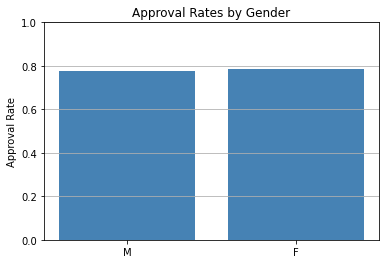

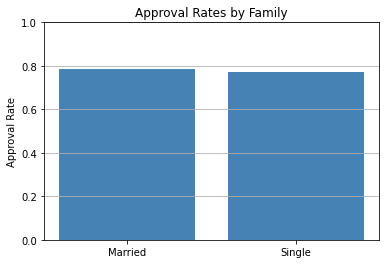

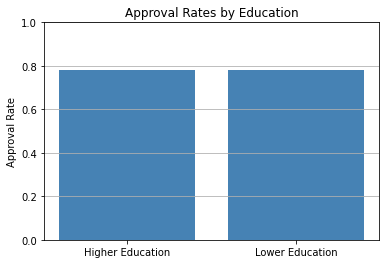

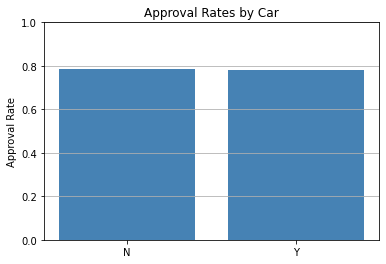

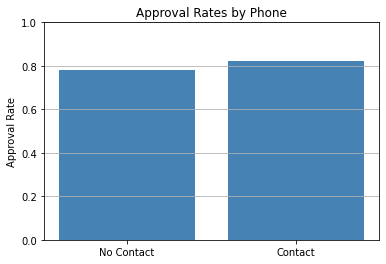

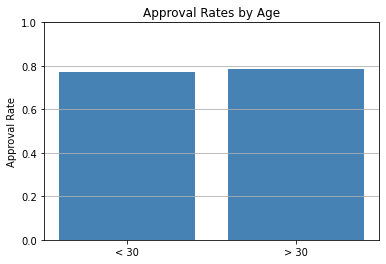

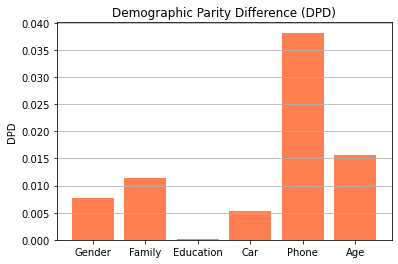

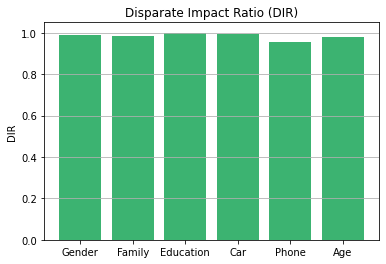

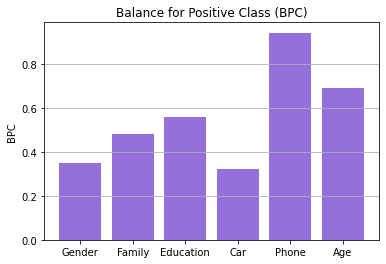

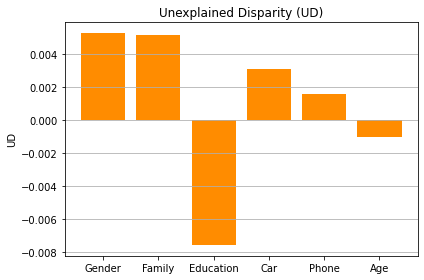

In [1]:
import matplotlib.pyplot as plt

# Labels for each attribute group
attributes = ['Gender', 'Family', 'Education', 'Car', 'Phone', 'Age']

# Provided data
AR_list = [
    [('M', 0.7779), ('F', 0.7857)],
    [('Married', 0.7849), ('Single', 0.7735)],
    [('Higher Education', 0.7820), ('Lower Education', 0.7822)],
    [('N', 0.785), ('Y', 0.7797)],
    [('No Contact', 0.7821), ('Contact', 0.8203)],
    [('< 30', 0.77), ('> 30', 0.7857)]
]
DPI_list = [0.0078, 0.0114, 0.0001, 0.00524, 0.0382, 0.0157]
DIR_list = [0.9901, 0.9855, 0.9998, 0.9933, 0.9535, 0.9800]
BPC_list = [0.3512, 0.4827, 0.5593, 0.3201, 0.9409, 0.6875]
UD_list = [0.0053, 0.0052, -0.0076, 0.0031, 0.0016, -0.001]

# Plot Approval Rates for each attribute
for i, (attr, group_rates) in enumerate(zip(attributes, AR_list)):
    groups, rates = zip(*group_rates)
    plt.figure()
    plt.bar(groups, rates, color='steelblue')
    plt.title(f'Approval Rates by {attr}')
    plt.ylabel('Approval Rate')
    plt.ylim(0, 1)
    plt.grid(axis='y')

# Plot DPI
plt.figure()
plt.bar(attributes, DPI_list, color='coral')
plt.title('Demographic Parity Difference (DPD)')
plt.ylabel('DPD')
plt.grid(axis='y')

# Plot DIR
plt.figure()
plt.bar(attributes, DIR_list, color='mediumseagreen')
plt.title('Disparate Impact Ratio (DIR)')
plt.ylabel('DIR')
plt.grid(axis='y')

# Plot BPC
plt.figure()
plt.bar(attributes, BPC_list, color='mediumpurple')
plt.title('Balance for Positive Class (BPC)')
plt.ylabel('BPC')
plt.grid(axis='y')

# Plot UD
plt.figure()
plt.bar(attributes, UD_list, color='darkorange')
plt.title('Unexplained Disparity (UD)')
plt.ylabel('UD')
plt.grid(axis='y')

plt.tight_layout()
plt.show()
